# Using Machine Learning to identify factors that impact salaries of Data-related Positions

___

For this project, I will be using real job data that I scraped from the MyCareersFuture portal. This is a job portal maintained by the Singapore Government for jobs in Singapore. 

The web scraping was done using another notebook and you can find my work in the notebook titled 'Web Scrapping - Using Selenium and Beautiful Soup'. The data was then sorted as a Pandas DataFrame and stored as a csv file.

In this notebook, I will be using cleaning and analyzing the data from the csv file, and use several machine learning models for prediction. 

### Key goal for this portion:
<br>
Determine the industry factors that are most important in predicting the salary amounts (whether low/high salary) for data-related jobs in Singapore. 

### Contents for this notebook:

1. Detailed steps & codes used, with explanation of each step
2. Executive Summary of findings at the end of the notebook

### Steps that I will be taking for this portion of the project:

1. Data Cleaning + Exploratory Data Analysis
    - Using Natural Language Processing (NLP) techniques for text data
2. Build a classification model for the prediction after resampling classes
    - Logistic Regression
    - Random Forest Classifier
3. Intepret the results of the models to refine the models
4. Summarize my findings and identify limitations

<font color='purple'>

# Data Cleaning + Exploratory Data Analysis

____

</font>

In [1]:
# Import basic packages for visualization

import pandas as pd
from pandas import DataFrame 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import all required packages for machine learning

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

In [3]:
# Load the csv file with info from web scrapping
    # Use pandas function to open the csv file
    
mcsg = './MyCareerSG1.csv'
mcsg = pd.read_csv(mcsg, index_col=0)

In [4]:
# Check the shape of the dataframe

mcsg.shape

(1466, 16)

In [5]:
# Open dataframe to check columns

mcsg.head(2)

,job_id,job_title,url,job_desc,job_req,yrs_exp,min_exp,indus,comp,sal_amt,sal_term,emp_type,num_app,posted_date,exp_date,address
0,JOB-2019-0019774,IT Executive (Data Analyst),https://www.mycareersfuture.sg/job/executive-s...,Sky Premium International is looking for IT Ex...,Requirements & Pre-Requisite : - Minimum a Deg...,Executive,3 years exp,Information Technology,SKY PREMIUM INTERNATIONAL PTE. LTD.,"$2,500to$4,000",Monthly,Full Time,3 applications,Posted 29 Apr 2019,Closing on 29 May 2019,"ONE RAFFLES PLACE, 1 RAFFLES PLACE 048616"
1,JOB-2019-0091291,Data Analyst,https://www.mycareersfuture.sg/job/data-analys...,•Frontline team members who have to mix solid ...,•Frontline team members who have to mix solid ...,Professional,4 years exp,Engineering,CAPGEMINI SINGAPORE PTE. LTD.,"$5,000to$7,500",Monthly,Permanent,1 application,Posted 29 Apr 2019,Closing on 29 May 2019,6 BATTERY ROAD 049909


__Explanation of the information available:__

    * job_id: Job listing ID
    * job_title: Job title 
    * url: URL of the job listing, where the data was scraped
    * job_desc: Description of the job
    * job_req: Requirements for the job
    * yrs_exp: Level of the job eg. Entry level / Professional
    * min_exp: Years of experience required for the job
    * indus: Job industry
    * comp: Name of company advertising for the job
    * sal_amt: Salary amount / range for the job
    * sal_term: Indicates if the salary amount is the monthly / annual salary
    * emp_type: Employment type e.g. Full-Time, Part-Time, Permanent, Contract
    * num_app: Number of applicants for the job at the time of web scrapping
    * posted_date: Date that job listing was posted
    * exp_date: Date that job listing will expire and stop taking in applicants
    * address: Address of the company


Recap on the main goals of our study:
    - Determine the industry factors that are most important in predicting the salary amounts
    
Keeping in line with the goals of our study, I will proceed to drop some columns from the dataframe that does not provide relevant information for the study

In [6]:
# Drop columns that are not relevant for the analysis

mcsg = mcsg.drop(['url','num_app','posted_date','exp_date'], axis=1)

## Removing duplicate entries
<br>

__Using Job ID to identify duplicates__

When converting the scraped information to dataframe earlier, I noticed that there were a few sites where information could not be retrieved for all columns. 

Since the Job ID should be unique for each listing, I will clean this column first to eliminate all duplicate information before starting to clean in detail.

In [7]:
# Check for null values in job id column. 
    # job id is the unique identifier of each job listing, hence if the job id is null, 
    # we will not be able to identify if the job listings are unique. 
    # Hence, we need all job id values to be non-null
print(mcsg[mcsg['job_id'].isnull()])

# Drop null values in job id column and reset index
mcsg = mcsg[~mcsg['job_id'].isnull()]
mcsg.reset_index(drop=True, inplace=True) 

     job_id job_title job_desc job_req yrs_exp min_exp indus comp sal_amt  \
573     NaN       NaN      NaN     NaN     NaN     NaN   NaN  NaN     NaN   
1070    NaN       NaN      NaN     NaN     NaN     NaN   NaN  NaN     NaN   

     sal_term emp_type address  
573       NaN      NaN     NaN  
1070      NaN      NaN     NaN  


In [8]:
# Check shape of the dataframe after dropping null values

mcsg.shape

(1464, 12)

In [9]:
# Check for duplicate job_id

len(mcsg['job_id'].unique())
    # There are only 1125 unique job ids in the entire dataframe with 1464 job ids

1125

In [10]:
# Drop duplicates based on job_id column

mcsg = DataFrame.drop_duplicates(mcsg, subset='job_id')

In [11]:
# Check shape of the dataframe
mcsg.shape

    # This shape is correct, based on the number of unique job id values identified earlier

(1125, 12)

__Using other columns to identify duplicates__

It is possible that some companies posted the same position multiple times, resulting in multiple job listings that are identical, but with a different job id. Here, we will check for that possbility and remove such duplicates.

Assumption: for jobs to be considered exactly the same, the job title, company, job description and requirements and salary amount should be the same. If a company posts the same job title with different description, requirements and salary amount, I will consider them to be a 'different' job. 

In [12]:
# Drop duplicates based on assumption of duplicates

mcsg = DataFrame.drop_duplicates(mcsg, subset=['job_title','comp','job_desc'])

In [13]:
# Check shape of the dataframe to get an idea of the number of listings left in the dataframe
mcsg.shape

(1041, 12)

In [14]:
# Reset index for dataframe
mcsg.reset_index(drop=True, inplace=True) 

## Cleaning Salary information

1. As most of the salary information comes in a range, we can split the salary information into 2 columns (Min and Max salary). 
2. Standardized all salary amounts as salary per month

In [15]:
# Split salary string to retrieve the min and max amount 

sal_amt_split = []

for sal in mcsg['sal_amt']:
    try:
        sal_amt_split.append(sal.split('to'))
    except AttributeError:
        sal_amt_split.append(np.nan)

In [16]:
# Add a sal_amt_min and sal_amt_max column for min and max salary amounts

sal_amt_min = []
sal_amt_max = []

for amt in sal_amt_split:
    try:
        sal_amt_min.append(int(amt[0].replace('$','').replace(',','')))
    except TypeError:
        sal_amt_min.append(np.nan)
    try:
        sal_amt_max.append(int(amt[1].replace('$','').replace(',','')))
    except TypeError:
        sal_amt_max.append(np.nan)
        
mcsg['sal_amt_min'] = sal_amt_min
mcsg['sal_amt_max'] = sal_amt_max

In [17]:
# Retrieve the index for sal_term = Annual

index_annual = mcsg[mcsg['sal_term'] == 'Annually'].index

# Change the min and max sal into monthly terms instead

mcsg.loc[index_annual,['sal_amt_min']] = mcsg['sal_amt_min'][index_annual]/12
mcsg.loc[index_annual,['sal_amt_max']] = mcsg['sal_amt_max'][index_annual]/12

In [18]:
# Set up a column that indicates the middle between the min and max salary range for each job listing

mcsg['sal_mid'] = (mcsg['sal_amt_min'] + mcsg['sal_amt_max']) / 2

    # This could be useful for building a regression model for predicting salary amount

In [19]:
# Drop the redundant columns, keeping only sal_amt_min and sal_amt_max

mcsg = mcsg.drop(['sal_amt','sal_term'], axis=1)

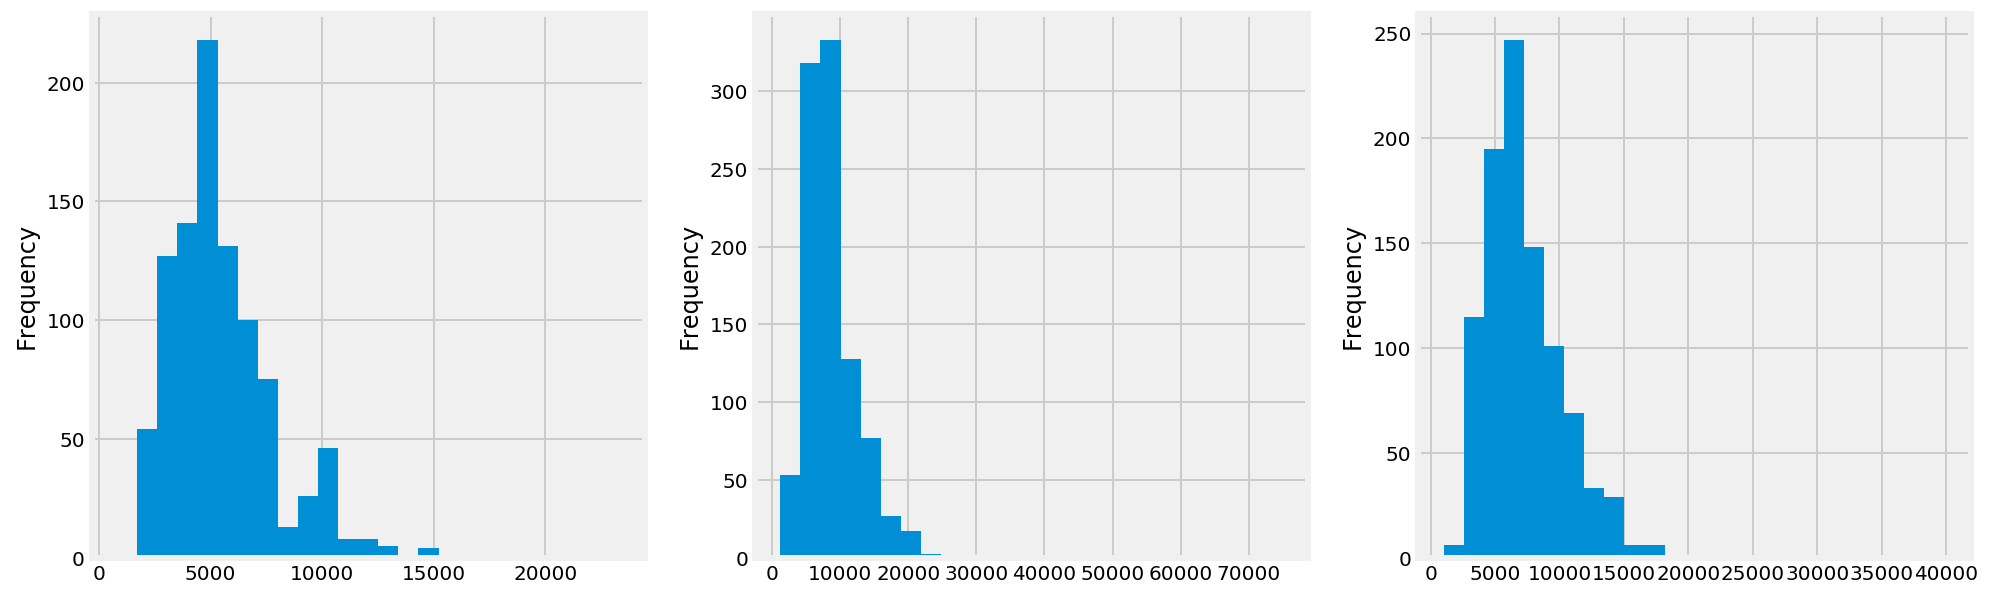

In [20]:
# Plot histograms for the salary features to check distribution
        
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

mcsg['sal_amt_min'].plot(kind='hist', bins=25, ax=ax1)
mcsg['sal_amt_max'].plot(kind='hist', bins=25, ax=ax2)
mcsg['sal_mid'].plot(kind='hist', bins=25, ax=ax3)

In [21]:
# Use the .describe() function to verify if there are any outliers

mcsg[['sal_amt_min','sal_amt_max','sal_mid']].describe()

,sal_amt_min,sal_amt_max,sal_mid
count,959.000000,959.000000,959.000000
mean,5576.615919,9028.707334,7302.661627
std,2355.307298,4896.943760,3342.940966
min,800.000000,1200.000000,1000.000000
25%,4000.000000,6000.000000,5000.000000
50%,5000.000000,8000.000000,6700.000000
75%,7000.000000,11000.000000,9000.000000
max,23333.333333,75000.000000,40000.000000


From the plots and information above, there seems to be some outliers in the salary features, that are skewing the graphs to the right. 

One possible reason for the outliers could be typo errors in the job listings, and one way to catch the error will be to see if there are any job listings where max salary is significantly higher than min salary. 

In [22]:
# Check if there are any job listings where the max salary is much higher than the min salary, e.g. by 4 times

mcsg[mcsg['sal_amt_max'] > 4*mcsg['sal_amt_min']]

,job_id,job_title,job_desc,job_req,yrs_exp,min_exp,indus,comp,emp_type,address,sal_amt_min,sal_amt_max,sal_mid
538,JOB-2019-0081258,Sr Sitecore Developer,Job Description Minimum 2 years of applicatio...,"2 years’ experience in designing, developing,...",Senior Executive,NaN,Information Technology,GATEWAY SEARCH PTE. LTD.,Permanent,"MARINA ONE WEST TOWER, 9 STRAITS VIEW 018937",5000.0,75000.0,40000.0
682,JOB-2019-0069111,Business Analyst - Factory Integration,In your new role you will: Be performing Da...,You are best equipped for this task if you hav...,"Professional, Junior Executive",NaN,Information Technology,INFINEON TECHNOLOGIES ASIA PACIFIC PTE LTD,Permanent,"INFINEON, 8 KALLANG SECTOR 349282",3000.0,45000.0,24000.0
708,JOB-2019-0067324,Business Analyst,3 yrs exp as Business Analyst/Scrum MAster ...,3 yrs exp as Business Analyst Certified Scrum ...,Middle Management,NaN,Information Technology,SANDBOX CONSULTING PTE. LTD.,Permanent,"TRIVEX, 8 BURN ROAD 369977",4000.0,70000.0,37000.0


Out of the job listings filtered out above, the last 3 job listings show max salaries that are close to 10 times more than min salaries, and does not seem reasonable. A more logical assumption is that there was a typo. I will amend the max amount down by removing a '0' from the amount

In [23]:
# Adjust typos for the max salaries for the listings above
# Adjust the median salary for the same listings as well

mcsg.loc[[538,682,708],'sal_amt_max'] = mcsg.loc[[538,682,708],'sal_amt_max']/10
mcsg.loc[[538,682,708],'sal_mid'] = (mcsg.loc[[538,682,708],'sal_amt_min'] + mcsg.loc[[538,682,708],'sal_amt_max']) /2

In [24]:
# Use the .describe() function to check the distribution of the salaries again after correcting the outliers.

mcsg[['sal_amt_min','sal_amt_max','sal_mid']].describe()

,sal_amt_min,sal_amt_max,sal_mid
count,959.000000,959.000000,959.000000
mean,5576.615919,8850.396594,7213.506257
std,2355.307298,3768.582701,2976.140503
min,800.000000,1200.000000,1000.000000
25%,4000.000000,6000.000000,5000.000000
50%,5000.000000,8000.000000,6550.000000
75%,7000.000000,10945.000000,9000.000000
max,23333.333333,33750.000000,28541.666667


To facilitate the study of factors that affect salary level, I will split sal_mid into 2 main categories to predict using a classification model later. 

The 2 categories will be __salaries higher than the overall mean__ and __salaries lower than the overall mean__. 

In [25]:
# Set up the salary range categories for the classification model later
    # I will use $7,200 (round down from $7,213.51)

sal_range = []

for value in mcsg['sal_mid'].values:
    if value <= 7200:
        sal_range.append(0)
    elif value > 7200 :
        sal_range.append(1)

    else:
        sal_range.append(np.nan)
        
# Add the salaries median range into the dataframe
mcsg['sal_range'] = sal_range

## Cleaning Employment Type

In [26]:
# Check the different employment types extracted from web scraping

mcsg['emp_type'].value_counts()

Full Time                                                            358
Permanent                                                            247
Permanent, Full Time                                                 157
Contract, Full Time                                                  120
Contract                                                             114
Permanent, Contract                                                   23
Permanent, Contract, Full Time                                         8
Full Time, Internship                                                  4
Temporary                                                              3
Part Time, Contract                                                    3
Contract, Internship                                                   1
Temporary, Contract, Full Time                                         1
Part Time, Permanent, Temporary, Freelance, Full Time, Internship      1
Internship                                         

From the results above, some of the job listings have more than 1 employment type tagged to them. However, many of the employment types are relatively repetitive, inconsistently tagged and uninformative. 

E.g. majority of the jobs in the market are Full Time jobs, however only some of the job listings were tagged as Full Time or Part Time, while the rest are not tagged. It may make more sense to remove the tag Full-Time, and only tag Part-Time when the job listing is for a part-time job. 

Hence, I will go ahead to re-categorize the employment type into a 4 main categories which are more informative instead, for easier analysis thereafter:
    # Permanent
    # Contract (Includes Temporary, since they are both are for a fixed duration)
    # Internship
    # Part Time

In [27]:
# Replace the categories that are not in our shortlisted categories with the final categories

def cleaning_emp_types(x):
    if x == 'Full Time':
        x = x.replace('Full Time','Permanent')
    elif x == 'Permanent, Full Time':
        x = x.replace('Permanent, Full Time','Permanent')
    elif x == 'Contract, Full Time':
        x = x.replace('Contract, Full Time','Contract')
    elif x == 'Permanent, Contract':
        x = x.replace('Permanent, Contract','Permanent')
    elif x == 'Permanent, Contract, Full Time':
        x = x.replace('Permanent, Contract, Full Time','Permanent')
    elif x == 'Part Time, Contract':
        x = x.replace('Part Time, Contract','Part Time')
    elif x == 'Full Time, Internship':
        x = x.replace('Full Time, Internship','Internship')
    elif x == 'Contract, Internship':
        x = x.replace('Contract, Internship','Internship')
    elif x == 'Part Time, Permanent, Temporary, Freelance, Full Time, Internship':
        x = x.replace('Part Time, Permanent, Temporary, Freelance, Full Time, Internship','Part Time')
    elif x == 'Temporary':
        x = x.replace('Temporary','Contract')
    elif x == 'Temporary, Contract, Full Time':
        x = x.replace('Temporary, Contract, Full Time','Contract')
    return x

mcsg['emp_type_clean'] = mcsg['emp_type'].map(lambda x: cleaning_emp_types(x))

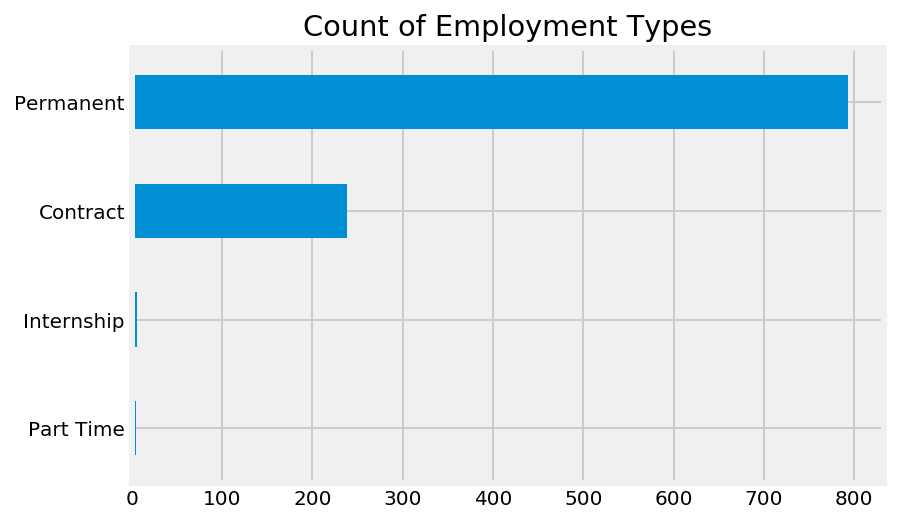

In [28]:
# Check the results of the data cleaning and proportion of each emp_type

mcsg['emp_type_clean'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Count of Employment Types');

In [29]:
# Check the relationship between different employment types and average salary

pd.get_dummies(mcsg[['emp_type_clean','sal_mid']]).corr()

,sal_mid,emp_type_clean_Contract,emp_type_clean_Internship,emp_type_clean_Part Time,emp_type_clean_Permanent
sal_mid,1.000000,-0.215607,-0.112395,0.068170,0.224496
emp_type_clean_Contract,-0.215607,1.000000,-0.041451,-0.033812,-0.973512
emp_type_clean_Internship,-0.112395,-0.041451,1.000000,-0.004729,-0.136150
emp_type_clean_Part Time,0.068170,-0.033812,-0.004729,1.000000,-0.111058
emp_type_clean_Permanent,0.224496,-0.973512,-0.136150,-0.111058,1.000000


Permanent roles are positively correlated with average salary. This can also be intepreted as permanent roles generally having a higher salary than the average of all job listings. This is a logical pattern. 

On the other hand, Contract and Internship roles are negatively correlated with average salary, which are logical patterns as well. 

However, the results currently show that Part Time positions are positively correlated with average salary, which does not seem logical. This is because part time jobs are usually paid lower. Hence, I will explore further to check if there could be anomalies.

In [30]:
# Check job listings which are Part Time

mcsg[mcsg['emp_type_clean'] == 'Part Time']

,job_id,job_title,job_desc,job_req,yrs_exp,min_exp,indus,comp,emp_type,address,sal_amt_min,sal_amt_max,sal_mid,sal_range,emp_type_clean
81,JOB-2019-0073402,Data Analyst,www.gigco.work www.simonestudios.com Gigco.wor...,"Responsibilities Interpret data, analyze resu...",Executive,NaN,Others,SIMONE STUDIOS PTE. LTD.,"Part Time, Permanent, Temporary, Freelance, Fu...",NaN,NaN,NaN,NaN,NaN,Part Time
502,JOB-2019-0082292,Business Analyst,"Key Responsibilities In this role, the Busines...",Essentials Skills and Qualifications: • At lea...,Professional,NaN,Banking and Finance,ROBERT WALTERS (SINGAPORE) PTE LTD,"Part Time, Contract",6 BATTERY ROAD 049909,11000.0,14000.0,12500.0,1.0,Part Time
552,JOB-2019-0079816,Senior OFSAA Consultants,The Senior OFSAA Technical Business Systems An...,Leverage understanding of high level system a...,"Professional, Executive",NaN,Information Technology,CAPGEMINI SINGAPORE PTE. LTD.,"Part Time, Contract",6 BATTERY ROAD 049909,10000.0,15000.0,12500.0,1.0,Part Time
553,JOB-2019-0079790,OFSAA Consultants,The OFSAATechnical Business Systems Analysts r...,Leverage understanding of high level system a...,"Professional, Executive",NaN,Information Technology,CAPGEMINI SINGAPORE PTE. LTD.,"Part Time, Contract",6 BATTERY ROAD 049909,5000.0,10000.0,7500.0,1.0,Part Time


After examining the details of the job listings that are tagged as 'Part-Time', I conclude that the job listings are not Part Time jobs but rather Full-Time positions. Hence, I will change the employment type to Contract instead, since they belonged to the Part-Time / Contract employment types originally. 

In [31]:
# Rerun the replacement of categories after taking into consideration the insights above
    # Replace the categories that are not in our shortlisted categories with the final categories

def cleaning_emp_types(x):
    if x == 'Full Time':
        x = x.replace('Full Time','Permanent')
    elif x == 'Permanent, Full Time':
        x = x.replace('Permanent, Full Time','Permanent')
    elif x == 'Contract, Full Time':
        x = x.replace('Contract, Full Time','Contract')
    elif x == 'Permanent, Contract':
        x = x.replace('Permanent, Contract','Permanent')
    elif x == 'Permanent, Contract, Full Time':
        x = x.replace('Permanent, Contract, Full Time','Permanent')
    elif x == 'Part Time, Contract':
        x = x.replace('Part Time, Contract','Contract')
    elif x == 'Full Time, Internship':
        x = x.replace('Full Time, Internship','Internship')
    elif x == 'Contract, Internship':
        x = x.replace('Contract, Internship','Internship')
    elif x == 'Part Time, Permanent, Temporary, Freelance, Full Time, Internship':
        x = x.replace('Part Time, Permanent, Temporary, Freelance, Full Time, Internship','Contract')
    elif x == 'Temporary':
        x = x.replace('Temporary','Contract')
    elif x == 'Temporary, Contract, Full Time':
        x = x.replace('Temporary, Contract, Full Time','Contract')
    return x

mcsg['emp_type_clean'] = mcsg['emp_type'].map(lambda x: cleaning_emp_types(x))

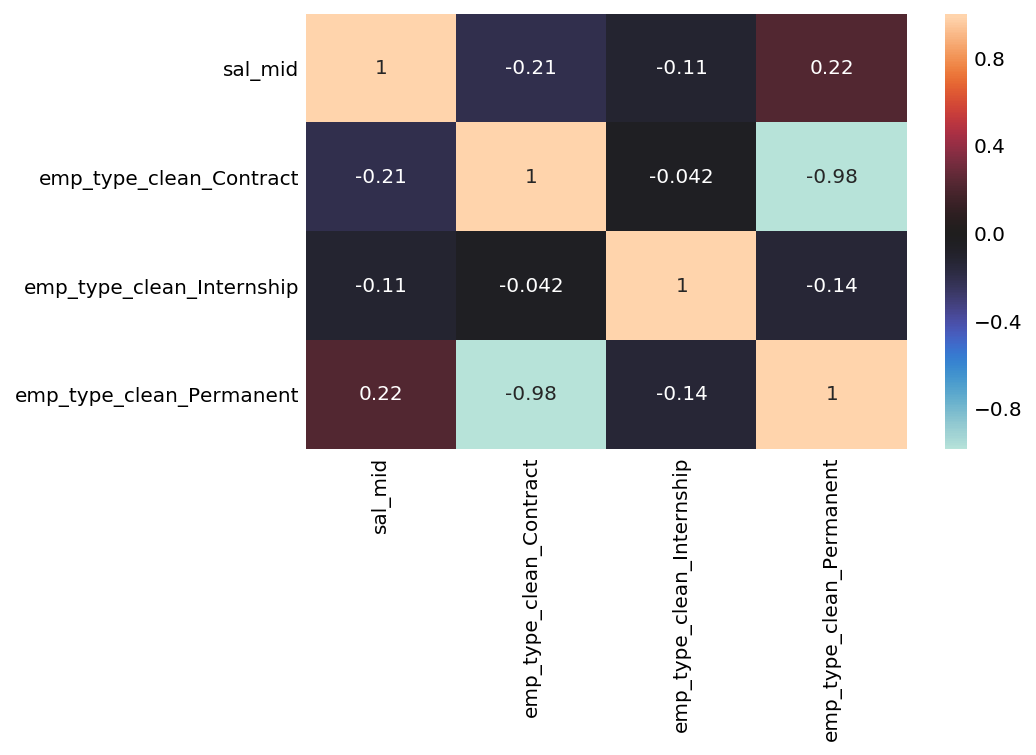

In [32]:
# Check the relationship between different employment types and average salary again

sns.heatmap(pd.get_dummies(mcsg[['emp_type_clean','sal_mid']]).corr(), center=0, annot=True)

The heat map above shows that permanent jobs are positively correlated with the average salary, while contract jobs and internships command salaries that are lower than the average, which is as per my understanding above.

In [33]:
# Drop the yrs_exp column to prevent duplicate and confusion 

mcsg = mcsg.drop('emp_type', axis=1)

## Cleaning Min Experience information

In [34]:
# Check the values in the column

print(mcsg['min_exp'].unique())
print('No. of null values: ',mcsg['min_exp'].isnull().sum())
print('% of null values: ',mcsg['min_exp'].isnull().sum()/mcsg['min_exp'].shape[0])

['3 years  exp' '4 years  exp' nan '7 years  exp' '2 years  exp'
 '8 years  exp' '5 years  exp' '10 years  exp' '9 years  exp'
 '1 year  exp' '6 years  exp']
No. of null values:  983
% of null values:  0.9442843419788665


As there are too many null values in this data, we cannot use this column as a feature for prediction. I will go ahead to drop this column. 

In [35]:
# Drop the min_exp column to prevent duplicate and confusion 

mcsg = mcsg.drop('min_exp', axis=1)

## Cleaning Seniority / Yrs Exp information

In [36]:
# Check the values in the columm to get a better idea on how to clean the data

print('Number of unique yrs_exp values: ', len(mcsg['yrs_exp'].unique()))

# Extract some of the unique values to take a look at the information
print('List of unique values:')
print(mcsg['yrs_exp'].unique())

Number of unique yrs_exp values:  45
List of unique values:
['Executive' 'Professional' 'Senior Executive'
 'Middle Management, Manager, Professional' nan 'Professional, Executive'
 'Junior Executive' 'Manager' 'Professional, Senior Executive'
 'Middle Management' 'Executive, Junior Executive'
 'Middle Management, Manager' 'Professional, Executive, Senior Executive'
 'Non-executive' 'Manager, Professional, Senior Executive'
 'Fresh/entry level' 'Manager, Executive' 'Senior Management'
 'Fresh/entry level, Junior Executive' 'Executive, Senior Executive'
 'Fresh/entry level, Junior Executive, Senior Executive'
 'Professional, Executive, Junior Executive, Senior Executive'
 'Fresh/entry level, Professional'
 'Fresh/entry level, Executive, Junior Executive'
 'Manager, Senior Executive'
 'Senior Management, Middle Management, Manager, Senior Executive'
 'Executive, Junior Executive, Senior Executive'
 'Fresh/entry level, Executive, Senior Executive'
 'Senior Management, Middle Management' '

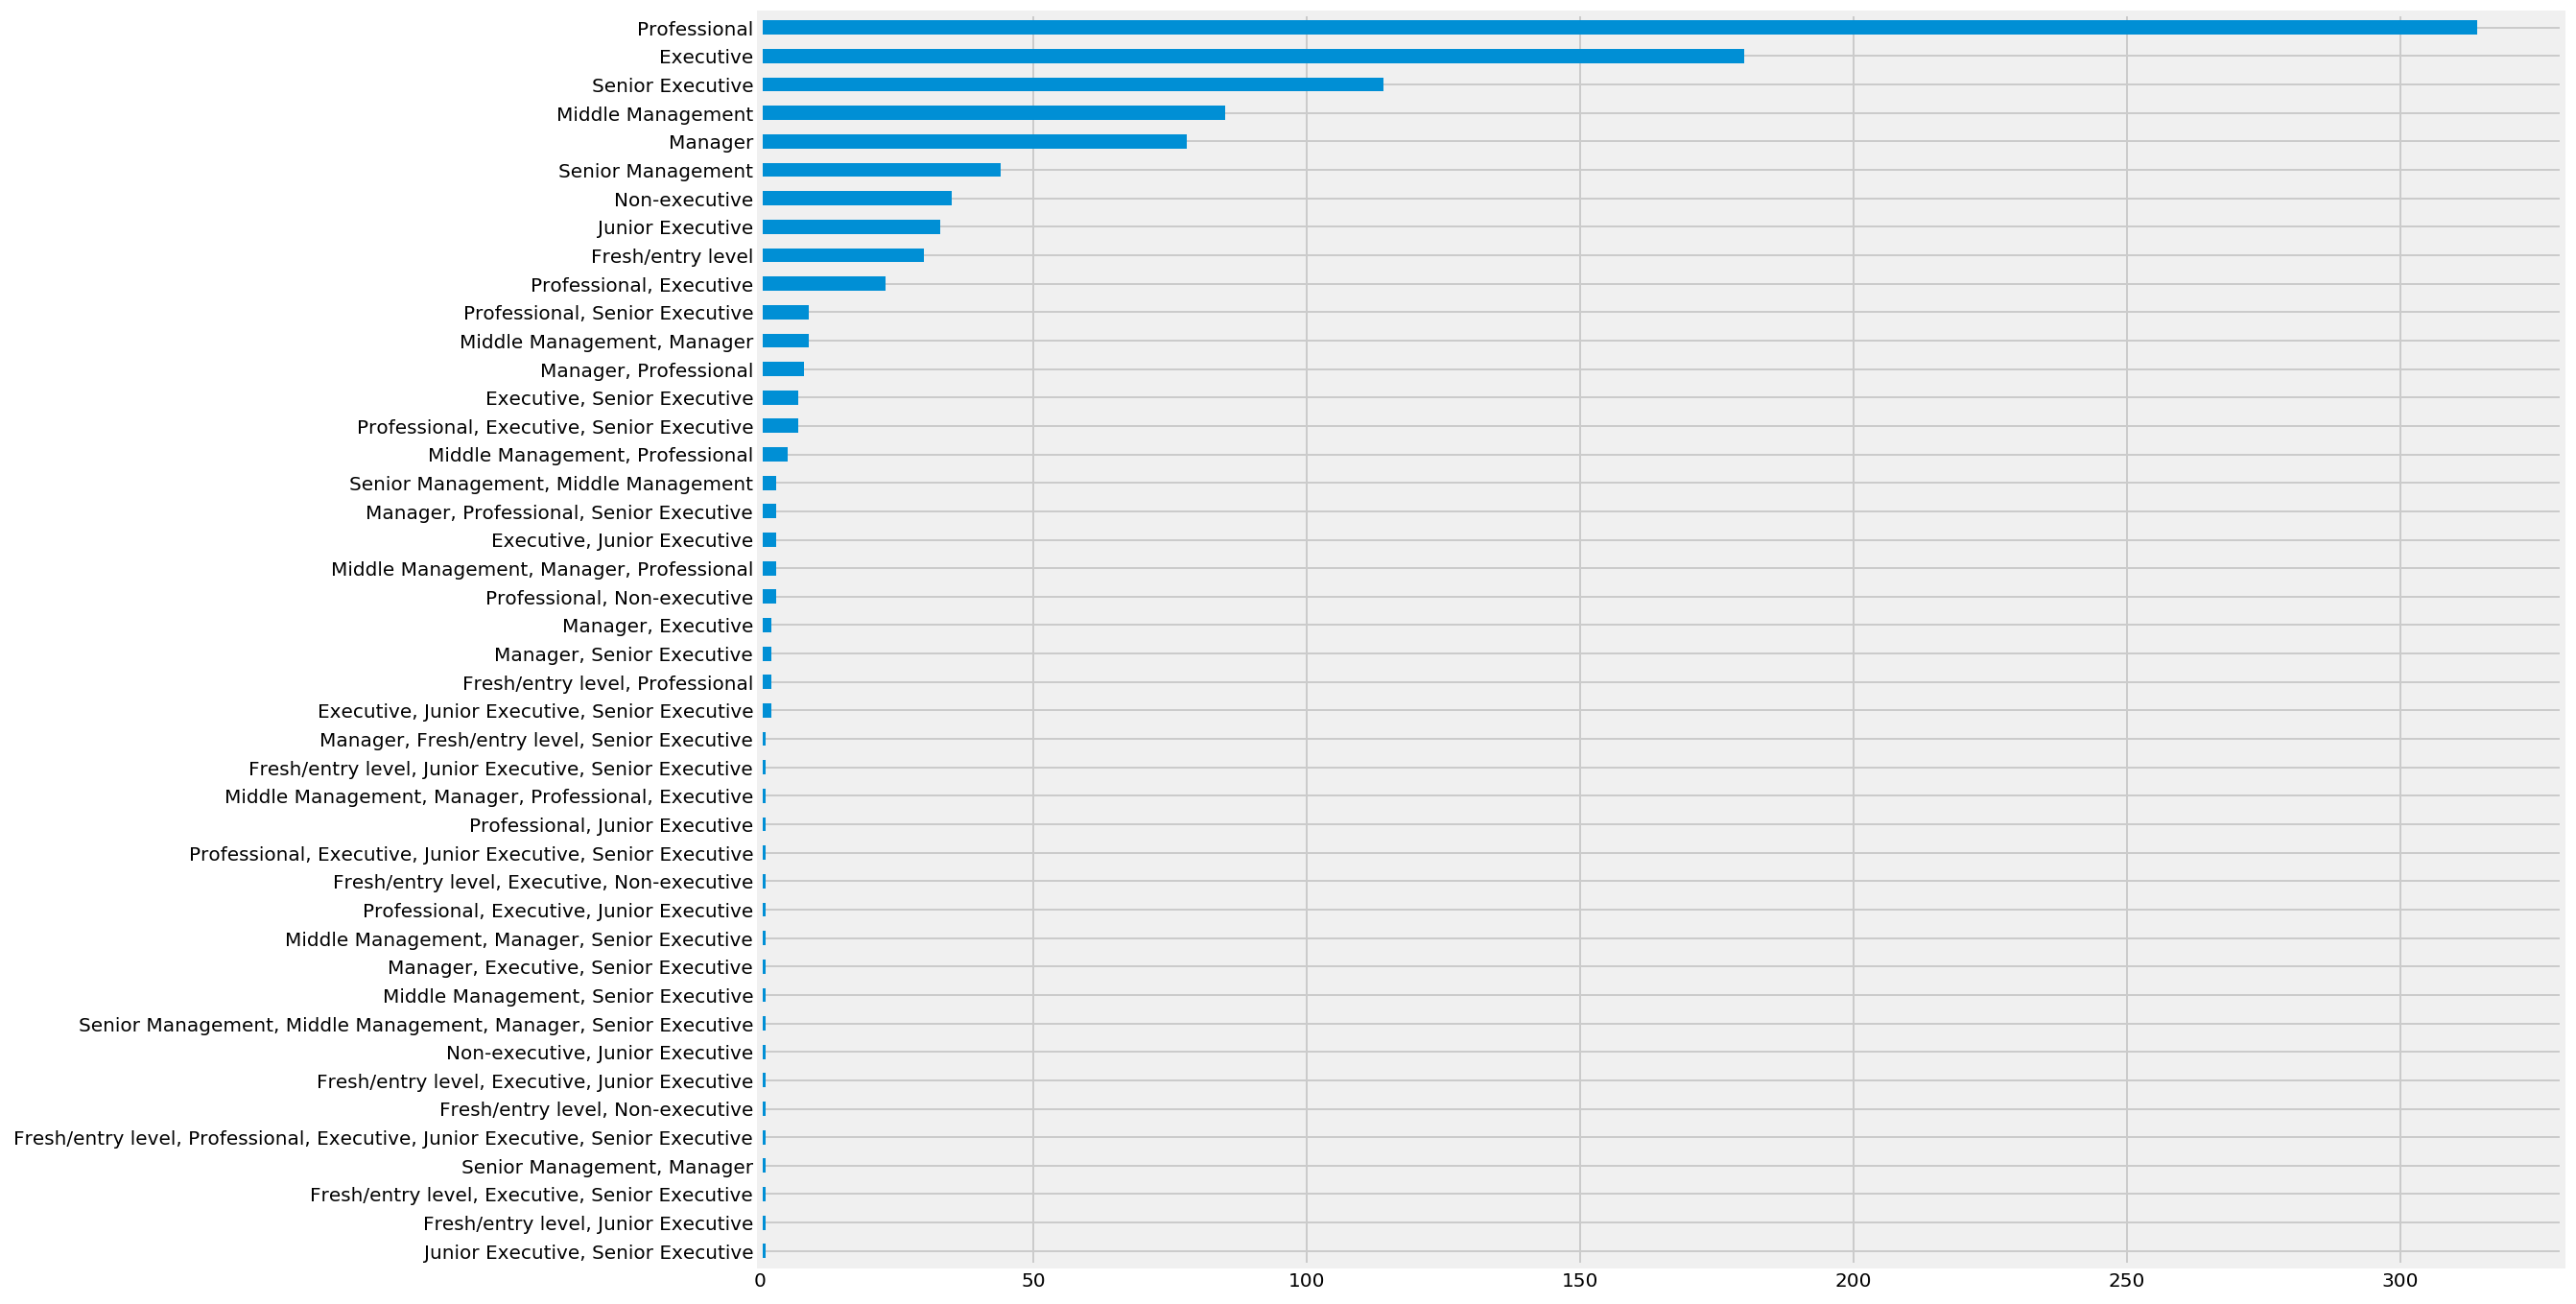

In [37]:
# Check the distribution of the different unique values

mcsg['yrs_exp'].value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(15,12));

There are the most number of 'Professional' followed by 'Executive'. Hence, I will try to retain these categories that have a large number of samples. From the types of seniority categories, I will group some similar categories together, to create meaningful and unique categories:

   * Professional
   * Executive - should also include Junior Executive and Senior Executive
   * Manager - should also include Middle Management and Senior Management
   * Fresh/entry level 
   * Non-executive 

In [38]:
# Recategorise and relabel the job listings - Executive, Non-executive, Manager, Professional, Fresh/entry level

seniority_list = []

for job in mcsg['yrs_exp']:
    job_seniority = []
    try:
        if 'Professional' in job:
            job_seniority.append('Professional')
        if 'Executive' in job or 'Junior Executive' in job or 'Senior Executive' in job:
            job_seniority.append('Executive')
        if 'Manager' in job or 'Middle Management' in job or 'Senior Management' in job:
            job_seniority.append('Manager')
        if 'Fresh/entry level' in job:
            job_seniority.append('Fresh/entry level')
        if 'Non-executive' in job:
            job_seniority.append('Non-executive')
    except TypeError:
        job_seniority.append(None)
    seniority_list.append(job_seniority)

In [39]:
# Append all seniority categories into a list

seniority_type = ['Professional','Executive','Manager','Fresh/entry level','Non-executive']

# Create columns in the dataframe for each seniority type, and mark 1 if the seniority type is tagged to job listing

for seniority in seniority_type:
    mcsg[seniority] = [1 if seniority in jobseniority else 0 for jobseniority in seniority_list]

In [40]:
# Check the number of counts of job listings in each seniority level

for seniority in seniority_type:
    print('Number of listings in',seniority,'is: ',mcsg[mcsg[seniority] == 1]['job_id'].count())

Number of listings in Professional is:  382
Number of listings in Executive is:  402
Number of listings in Manager is:  249
Number of listings in Fresh/entry level is:  40
Number of listings in Non-executive is:  41


In [41]:
# Study if these categories have a relationship with average salary

for seniority in seniority_type:
    print('Mean Salary of',seniority,' : ',np.mean(mcsg[mcsg[seniority] == 1]['sal_mid']))

Mean Salary of Professional  :  7270.682736455463
Mean Salary of Executive  :  6310.984210526317
Mean Salary of Manager  :  9276.30604719764
Mean Salary of Fresh/entry level  :  4328.6324786324785
Mean Salary of Non-executive  :  5818.333333333333


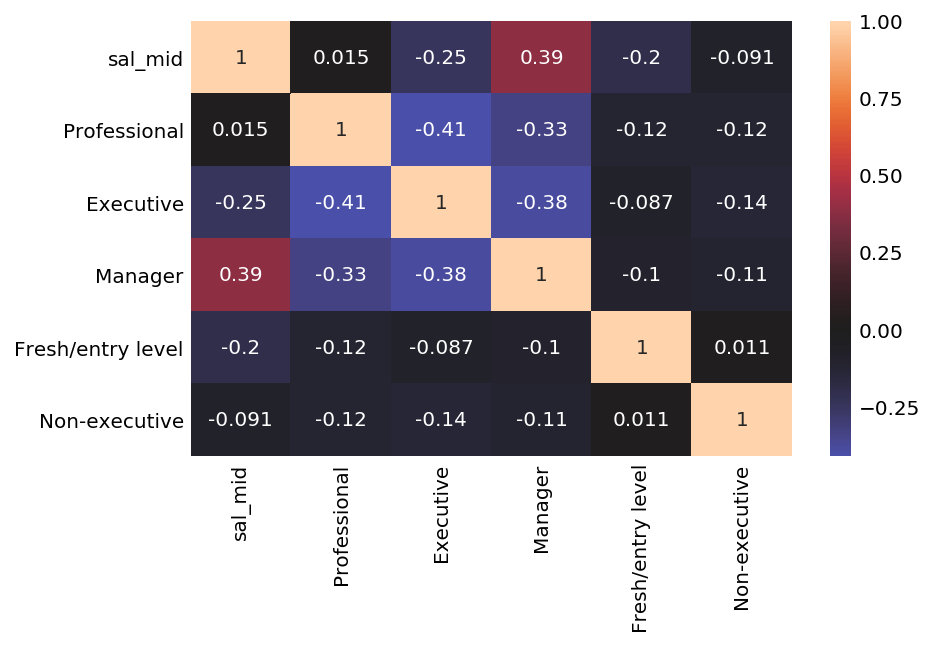

In [42]:
# Study if these categories have a relationship with average salary

sns.heatmap(mcsg[['sal_mid','Professional','Executive','Manager','Fresh/entry level','Non-executive']]
            .corr(),center=0,annot=True);

There is a clear difference in mean salary for different job title categories. In addition, their correlation to average salary is different and makes logical sense. E.g. salaries of Professional and Manager have a positive correlation and are higher than the overall average salary.

In [44]:
# Drop the job_title column to prevent duplicate and confusion 

mcsg = mcsg.drop('yrs_exp', axis=1)

## Cleaning Job Title information

As there are many different job titles, I will clean this data to categorize the jobs into fixed categories. 

Based on Edvancer Eduventures (https://www.edvancer.in/10-data-science-job-roles-must-know/), here are some of the job titles related to Data:
   * Data Scientist
   * Data Analyst / Business Analyst
   * Data Engineer

Based on EDA on the job titles, I also noticed that a substantial number of roles are for the academic field (e.g. Lecturer or Research Fellow) or for Management positions. The small number of diverse roles that do not fall under the main categories will be labelled 'Others'.  
   * Academic
   * Management
   * Others

In [45]:
# Convert all text to lowercase to facilitate data cleaning 

mcsg['job_title'] = [job.lower() for job in mcsg['job_title'].values]

In [46]:
# Categorizing job title 

def categorize_job_title(job):

    if 'analyst' in job:
        job = 'data/business analyst'
    elif 'scientist' in job:
        job = 'data scientist'
    elif 'engineer' in job or 'architect' in job:
        job = 'data architect/engineer'
    elif 'research' in job or 'lecturer' in job or 'professor' in job:
        job = 'academics'  
    elif 'manager' in job or 'president' in job or 'vp' in job or 'director' in job:
        job = 'management'
    else:
        job = 'others'
    return job

In [47]:
# Apply the categorizing function on all job listings

mcsg['job_title_clean'] = mcsg['job_title'].map(lambda x: categorize_job_title(x))

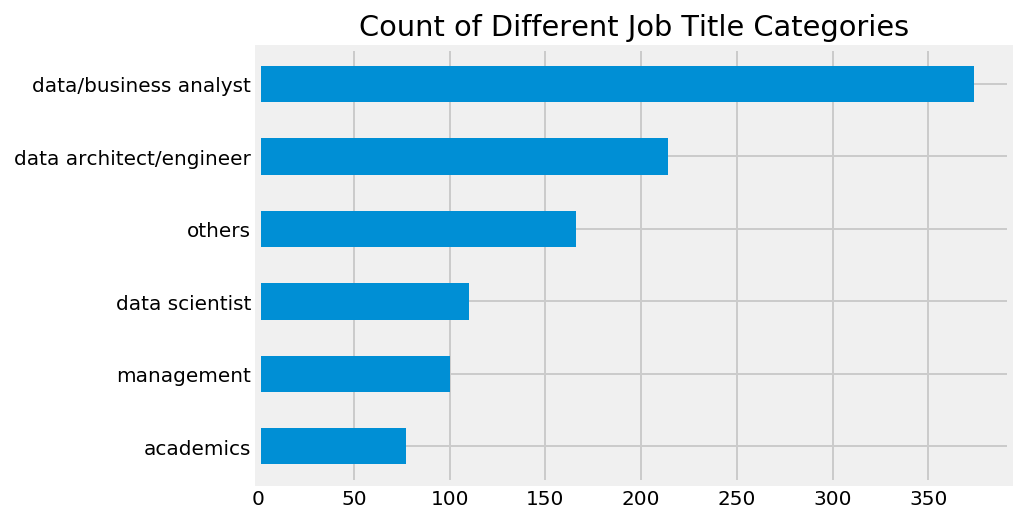

In [48]:
# Check the distribution of the different categories after cleaning

mcsg['job_title_clean'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Count of Different Job Title Categories');

There is a good distribution of the different categories (at least 50+ samples for each category), as seen from the plot above. 

In [49]:
# Study if these categories have a relationship with average salary

for categories in mcsg['job_title_clean'].unique():
    print('Mean Salary of',categories,' : ',np.mean(mcsg[mcsg['job_title_clean'] == categories]['sal_mid']))

Mean Salary of data/business analyst  :  6826.180840664712
Mean Salary of data architect/engineer  :  7370.725000000001
Mean Salary of others  :  7029.644373673035
Mean Salary of data scientist  :  7711.891025641025
Mean Salary of management  :  9807.785714285714
Mean Salary of academics  :  5292.260273972603


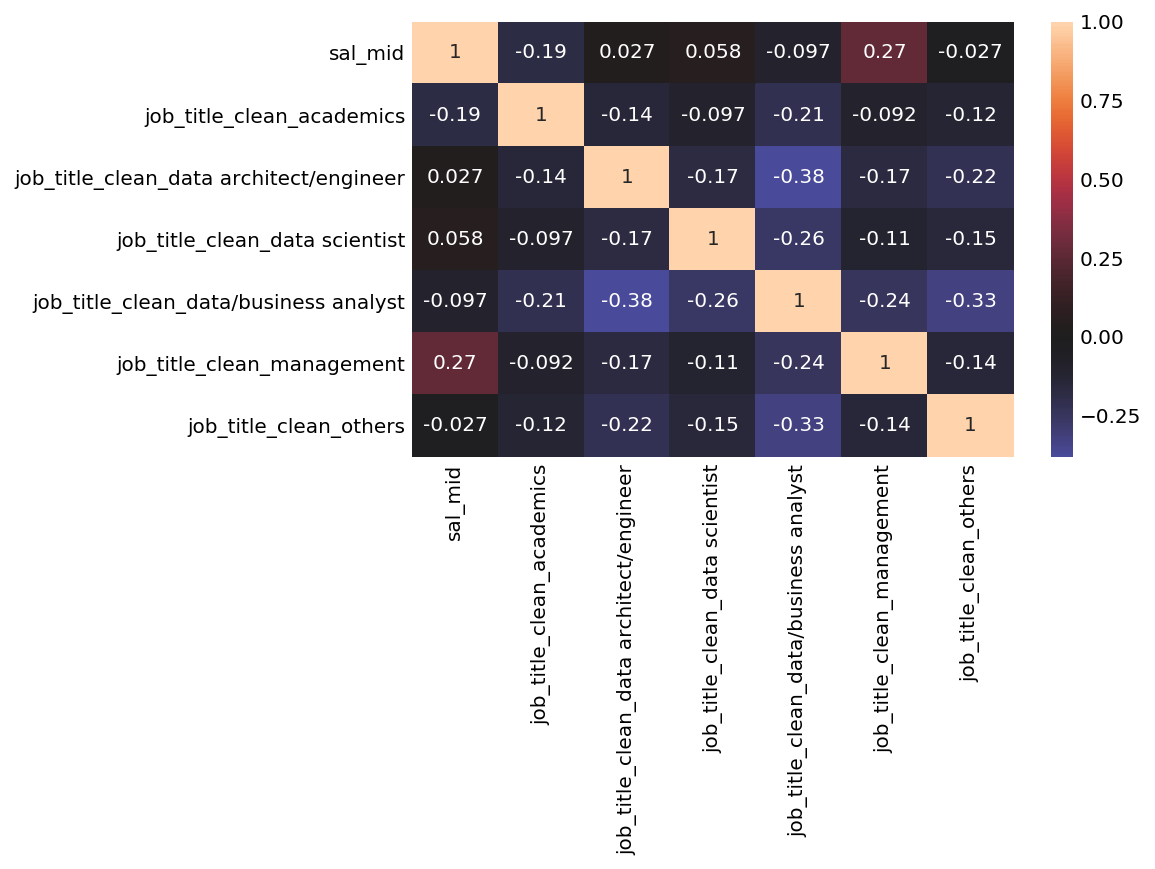

In [50]:
# Study if these categories have a relationship with average salary

sns.heatmap(pd.get_dummies(mcsg[['sal_mid','job_title_clean']]).corr(),center=0,annot=True);

While there is an obvious difference in the mean salary amount for different job titles, the correlation between job title and mean salary is not as clear compared to other features that we have examined so far. 

Hence, this may possibly not be as important a feature for predicting salary. 

In [52]:
# Drop the job_title column to prevent duplicate and confusion 

mcsg = mcsg.drop('job_title', axis=1)

## Cleaning Industry information

Each job may have more than 1 industry tag attached to it, and all of these industry tags are informative. Hence, I will create new columns in the dataframe to store the industry tags information as binaries in the new columns. These act as 'dummy' columns.

In [53]:
# Get a list of all the different industries

indus_list = []

for value in mcsg['indus'].values:
    value = value.split(', ')
    for subvalue in value:
        if subvalue not in indus_list:
            indus_list.append(subvalue)
        
print(indus_list)
    # Check all the different industries

['Information Technology', 'Engineering', 'Admin / Secretarial', 'Banking and Finance', 'Public / Civil Service', 'Advertising / Media ', 'Consulting ', 'Accounting / Auditing / Taxation', 'Logistics / Supply Chain', 'Others', 'Insurance', 'General Management', 'Sciences / Laboratory / R&D', 'Professional Services', 'Sales / Retail ', 'Customer Service', 'Education and Training', 'Telecommunications', 'Risk Management', 'Environment / Health  ', 'Healthcare / Pharmaceutical', 'Manufacturing', 'Building and Construction', 'Design', 'Repair and Maintenance', 'Marketing / Public Relations ', 'Travel / Tourism', 'Human Resources ', 'Legal', 'Events / Promotions ', 'General Work']


In [54]:
# Create columns in the dataframe for each industry, and mark 1 if the industry is tagged to the job listing

for indus in indus_list:
    mcsg[indus] = [1 if indus in jobindus else 0 for jobindus in mcsg['indus'].values]

In [55]:
# Drop the indus column to prevent duplicate and confusion 

mcsg = mcsg.drop('indus', axis=1)

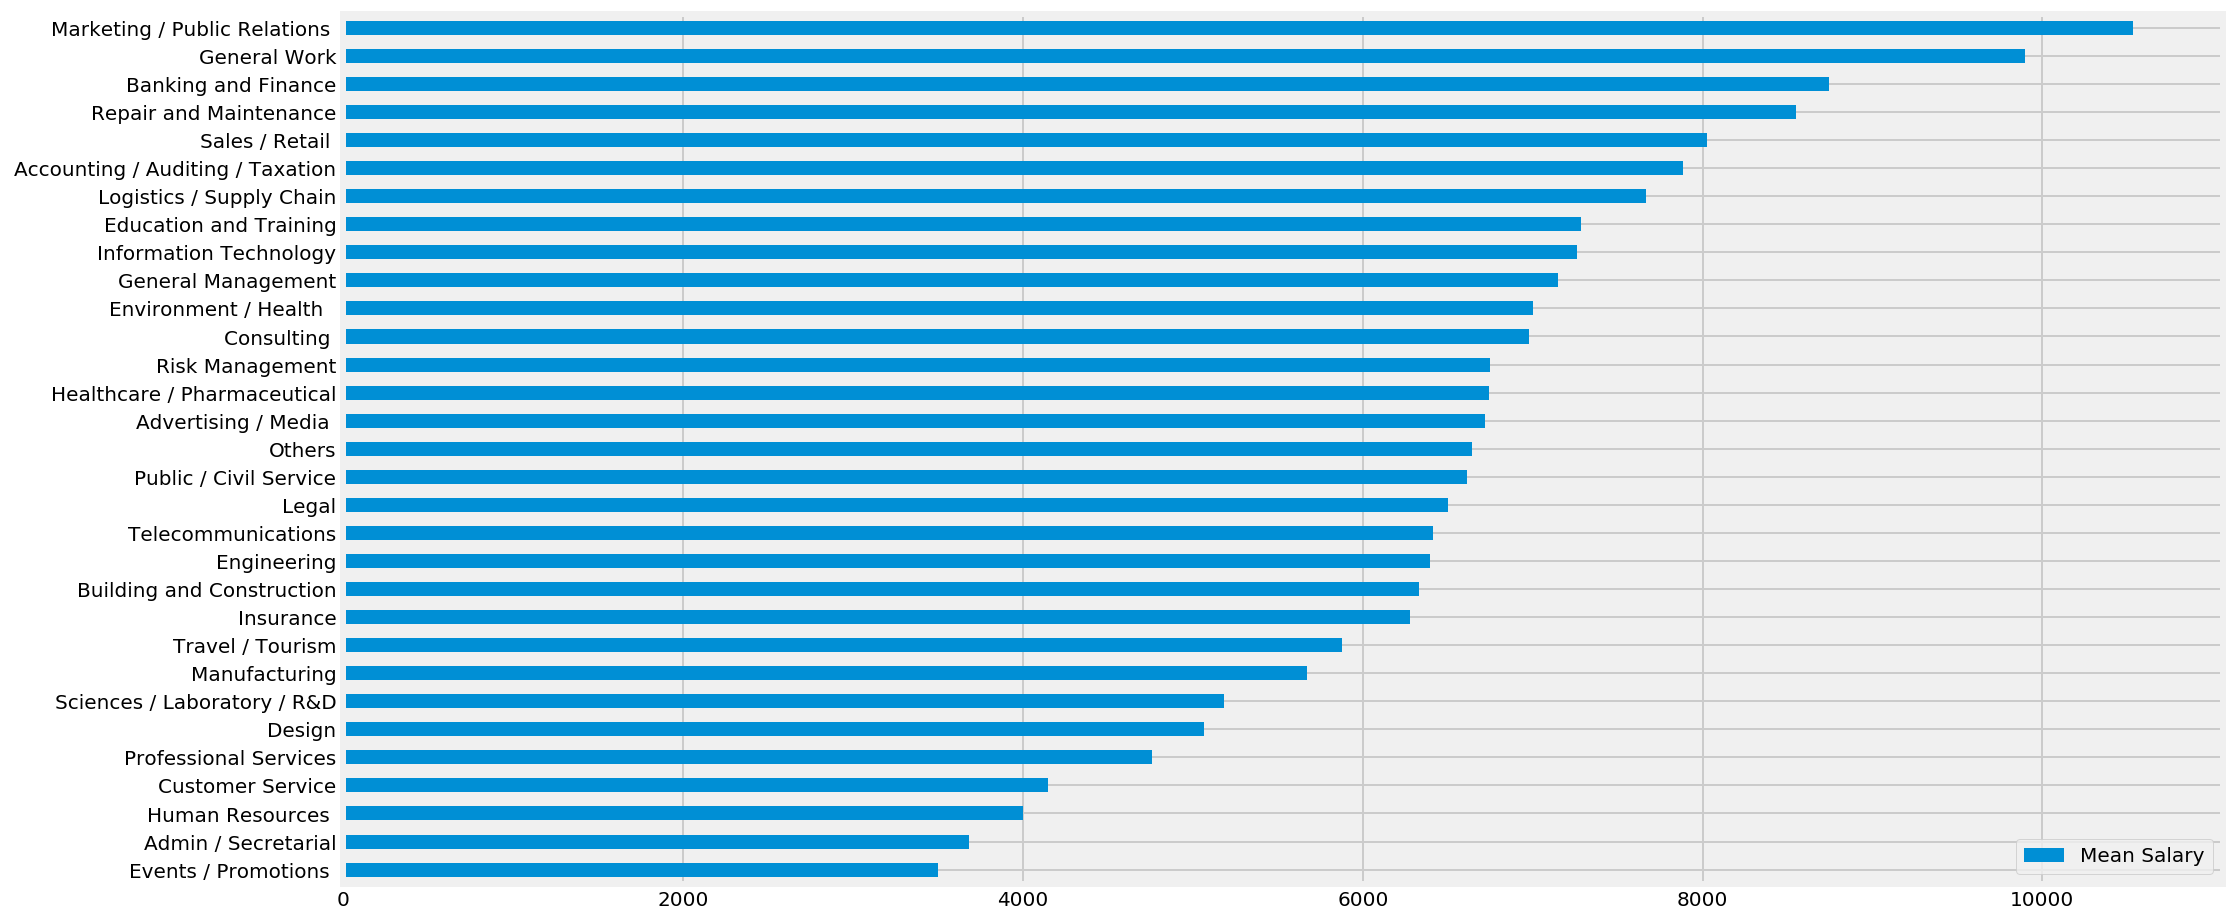

In [56]:
# Study if these categories have a relationship with average salary

indus_sal_list = []

for indus in indus_list:
    indus_sal_list.append(np.mean(mcsg[mcsg[indus] == 1]['sal_mid']))
    
pd.DataFrame(indus_sal_list,indus_list, columns=['Mean Salary']).sort_values(by='Mean Salary', 
                                                                             ascending=True).plot(kind='barh', 
                                                                                                  figsize=(15,8))

From the plot above, there is a range of different salary amounts across the industries. However, there are also many industries with a similar mean salary e.g. There are 17 industries with salaries in the range from $6000-8000.

In [57]:
# Check the number of counts of job listings in each industry

for indus in indus_list:
    print('Number of listings in',indus,'is: ',mcsg[mcsg[indus] == 1]['job_id'].count())

Number of listings in Information Technology is:  621
Number of listings in Engineering is:  118
Number of listings in Admin / Secretarial is:  3
Number of listings in Banking and Finance is:  140
Number of listings in Public / Civil Service is:  68
Number of listings in Advertising / Media  is:  18
Number of listings in Consulting  is:  39
Number of listings in Accounting / Auditing / Taxation is:  16
Number of listings in Logistics / Supply Chain is:  15
Number of listings in Others is:  45
Number of listings in Insurance is:  9
Number of listings in General Management is:  12
Number of listings in Sciences / Laboratory / R&D is:  96
Number of listings in Professional Services is:  8
Number of listings in Sales / Retail  is:  14
Number of listings in Customer Service is:  6
Number of listings in Education and Training is:  23
Number of listings in Telecommunications is:  13
Number of listings in Risk Management is:  7
Number of listings in Environment / Health   is:  1
Number of list

There are many industries that have very few job listings, and this may become a limitation for the study for industry related factors.

## Save cleaned data to a csv
Since I have cleaned the bulk of the data now, I will store the cleaned data in a csv file for future usage in a different notebook.

In [60]:
mcsg.to_csv('./CleanedJobsData.csv')

## Split data into train and test set

All columns except Job Description and Job Requirements have been cleaned. As these 2 columns contain texts, the most effective way to study the data in these columns would be using Natural Language Processing (NLP) techniques e.g. Term Frequency – Inverse Document Frequency Vectorizer (TF-IDF). 

Before I start doing that, I will split the dataset into train and test set first. This is because the best practice for using the TF-IDF technique requires training separately only on the train data, before using the same parameters to transform the test data. 

_____

I wil be building a classification model to predict salary range. 

__Target variable:__
* Salary range ('sal_range')
    - Whether the salary is above $7,200: class 0 
    
    - Whether the salary is $7,200 or below: class 1 
    
<br>

__Possible prediction variables:__
* Entry level
* Different industries
* Job Title categories
* Employment type
* Job Description and Requirements

____

In [61]:
# Set up dataframe for variables that will be used as predictor or targe variables

variables = mcsg.drop(['job_id','comp','address','sal_amt_min','sal_amt_max','sal_mid'], axis=1)

In [62]:
# Check the number of null values in the variables dataframe
variables.isnull().sum()

job_desc                             0
job_req                             67
sal_range                           82
emp_type_clean                       0
Professional                         0
Executive                            0
Manager                              0
Fresh/entry level                    0
Non-executive                        0
job_title_clean                      0
Information Technology               0
Engineering                          0
Admin / Secretarial                  0
Banking and Finance                  0
Public / Civil Service               0
Advertising / Media                  0
Consulting                           0
Accounting / Auditing / Taxation     0
Logistics / Supply Chain             0
Others                               0
Insurance                            0
General Management                   0
Sciences / Laboratory / R&D          0
Professional Services                0
Sales / Retail                       0
Customer Service         

In [63]:
# Drop the null values in the salary range column 
    # Since these will not be of value to us when we are trying to predict salary range
# Also drop the null values for the entry level column 
    # Since there are only 18 null values

variables = variables[~variables['sal_range'].isnull()]

In [64]:
# Set up the predictor and target variables

X = variables.drop('sal_range', axis=1)
y = variables['sal_range']

In [65]:
# Set up the train and test set, stratifying based on the labels in y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=1)

In [66]:
# I will not be standardizing the features in this case, as they are mostly binary values or token counts, 
# which are not drastically different in scale

## Study the job description column

Use Term Frequency–Inverse Document Frequency (TF-IDF) Vectorizer for feature extraction in job description and job requirements column to extract the most important words found in the all job listings. 
TF-IDF works by taking into consideration both the frequency of a word in a document, as well as the frequency in the corpus of documents. 

In addition, I will combine job description and job requirements together as there is likely repetitive information in these 2 columns, since both columns detail the factors important for a job listing.

In [67]:
# Create a function to combine job description and job requirements together
    # So we can use this function on both the train and test set

def combine_text(df, col1, col2):
    # df is the dataframe we are working with
    # col1 and col2 are the name of the columns to be combined together
    # returns the combined text
    
    text = []

    for index_desc, desc in enumerate(df[col1].values):
        try:
            text.append(desc+df[col2].values[index_desc])
        except TypeError:
            text.append(desc)
        
    return text

In [68]:
# Create a function to use SnowballStemmer to do stemming of words in all the text
    # So we can use this function on both the train and test set

def stem_text(combined_text,df,col3):
    # combined_text is the output from the function combine_text
    # df is the dataframe we are working with
    # col3 is the name of the new column that the stemmed text will be added to
    
    stemmer = SnowballStemmer("english")
    stemmed_text = []

    for job in combined_text:
        job = stemmer.stem(job)
        stemmed_text.append(job)
    
    df[col3] = stemmed_text
    return df

In [69]:
# Apply the functions on both the train and test set

X_train = stem_text(combine_text(X_train,'job_desc','job_req'),X_train,'job_desc_req')
X_test = stem_text(combine_text(X_test,'job_desc','job_req'),X_test,'job_desc_req')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [70]:
# Fit TF-IDF Vectorizer to the data
   # I played around with some of the parameters e.g. min_df and ngram_range. The hyperparameters used below 
   # are the most optimal ones that I had tried

# The top results consists of some irrelvant words that do not tell much, e.g. requirements, work, shortlisted, candidates
# Hence, I will add those words to stop_words

stopwords = list(stop_words.ENGLISH_STOP_WORDS)

stop = ['requirements','work','candidates','shortlisted','end','regret','notified']

for word in stop:
    stopwords.append(word)

tvec = TfidfVectorizer(min_df=0.05, ngram_range=(2,4), stop_words=stopwords)
tvec.fit(X_train['job_desc_req'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
        ngram_range=(2, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['was', 'that', 'twelve', 'whereafter', 'own', 'is', 'someone', 'after', 'least', 'had', 'therefore', 'further', 'latter', 'he', 'along', 'eleven', 'interest', 'beforehand', 'beside', 'elsewhere', 'often', 'see', 'once', 'hundred', 'up', 'forty', 'where', 'yet', 'and', 'nor', 'there', 'tw...', 'thin', 'here', 'requirements', 'work', 'candidates', 'shortlisted', 'end', 'regret', 'notified'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [71]:
# Transform X_train using the vectorizer 

job_desc_req_words = tvec.transform(X_train['job_desc_req'])
columns = np.array(tvec.get_feature_names())

In [72]:
# Set up function to retrieve the most common words found using the Vectorizer

def get_freq_words(sparse_counts, columns):
    word_counts = np.asarray(sparse_counts.sum(axis=0)).reshape(-1)

    largest_count_indices = word_counts.argsort()[::-1]
    freq_words = pd.Series(word_counts[largest_count_indices], 
                            index=columns[largest_count_indices])

    return freq_words

In [73]:
get_freq_words(job_desc_req_words,columns)

machine learning                78.957465
big data                        59.693768
years experience                50.224564
computer science                49.003988
communication skills            47.192501
data analytics                  45.085213
business analyst                42.939843
data science                    35.425615
experience working              34.895537
problem solving                 33.402173
project management              31.463991
deep learning                   30.800294
bachelor degree                 30.623117
team player                     29.965680
best practices                  27.350853
degree computer                 26.509867
software development            25.802035
business processes              25.775755
degree computer science         25.440742
working experience              25.399170
minimum years                   25.055765
data analysis                   24.911067
hands experience                24.740979
business analysis               24

In [74]:
# Join the TF-IDF info back to the main DataFrame for X_train

    # Create separate Dataframe for CountVectorized info first
tvec_job = pd.DataFrame(job_desc_req_words.todense(),columns=columns)

    # Concatenate the CountVectorized info with the main dataframe
X_train.reset_index(drop = True, inplace = True) 
X_train = pd.concat([X_train,tvec_job],axis=1)

    # Drop the 'job_desc' and 'job_req' columns
X_train = X_train.drop(['job_desc','job_req','job_desc_req'],axis=1)

In [75]:
# Get dummies for X_train
X_train = pd.get_dummies(X_train, drop_first=True)

In [76]:
# Process X_test in the same way

 # Transform the text in X_test in the same steps, using the same parameters as X_train

job_desc_req_words_test = tvec.transform(X_test['job_desc_req'])

 # Create separate Dataframe for CountVectorized info first
tvec_job_test = pd.DataFrame(job_desc_req_words_test.todense(),columns=columns)

    # Concatenate the CountVectorized info with the main dataframe
X_test.reset_index(drop = True, inplace = True) 
X_test = pd.concat([X_test,tvec_job_test],axis=1)

    # Drop the 'job_desc' and 'job_req' columns
X_test = X_test.drop(['job_desc','job_req','job_desc_req'],axis=1)

In [77]:
# Get dummies for X_train
X_test = pd.get_dummies(X_test, drop_first=True)

In [78]:
# Check if X_train and X_test have the same number of columns after transformation

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('Difference between X_train and X_test: ',set(X_train.columns)-set(X_test.columns))

X_train shape:  (815, 161)
X_test shape:  (144, 161)
Difference between X_train and X_test:  set()


# Build a classification model to predict salary

### First, check the baseline

In [79]:
# Calculate the baseline for the classification prediction - train set

print(y_train.value_counts())
print('The baseline is ',481/len(y_train.values))

0.0    481
1.0    334
Name: sal_range, dtype: int64
The baseline is  0.5901840490797546


In [80]:
# Calculate the baseline for this classification prediction - test set

print(y_test.value_counts())
print('The baseline is ',85/len(y_test.values))

0.0    85
1.0    59
Name: sal_range, dtype: int64
The baseline is  0.5902777777777778


#### Based on the baseline calculation, there is only a slight class imbalance (60% vs 40%). Hence, I will look into resampling to correct the class imbalance.

### Logistic Regression Model

I will build a basic logistic regression model for the classification, as it is a simple model that can act as a baseline for me as I explore other machine learning models thereafter. 

In [81]:
# Build a basic Logistic Regression model before resampling
    # I chose cv = 3 as the sample size is not very big

logreg = LogisticRegression(solver='liblinear')
cross_val_score(logreg,X_train,y_train,cv=3)

array([0.73260073, 0.77859779, 0.76752768])

Using a simple logistic regression model, the accuracy score is already better than the baseline.

I will proceed to fine tune the logistic regression model and try other models to obtain better results. One of the fine-tuning methods is resampling to fix the imbalanced class.

In [82]:
# Resampling using SMOTE across a range of different k_neighbors to find the best k_neighbors value
    # I am iterating through a range of k to get the best auc score
        
for k in range(1,25,1):
    
    skf = StratifiedKFold(n_splits=3, random_state=2, shuffle=True)
    score= []

    for train_index, test_index in skf.split(X_train,y_train):
        X_cross_train, X_cross_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        sm = SMOTE(ratio='minority',k_neighbors=k, random_state=240)
        X_smote, y_smote = sm.fit_sample(X_cross_train, y_cross_train)
        
        logreg.fit(X_smote, y_smote)
        y_pred = logreg.predict(X_cross_test)
        y_pred_proba = logreg.predict_proba(X_cross_test)
        
        fpr, tpr, _ = roc_curve(y_cross_test, y_pred_proba[:,1])
        roc_auc = auc(fpr, tpr)
        
        score.append(roc_auc)

    print('k: ',k,'mean auc: ', np.mean(score), 'std: ', np.std(score))

k:  1 mean auc:  0.8179402450365183 std:  0.013647338144224572
k:  2 mean auc:  0.8173623767956067 std:  0.014971041115728407
k:  3 mean auc:  0.8196024551614615 std:  0.01668037588638379
k:  4 mean auc:  0.8157428002536699 std:  0.015100495430823037
k:  5 mean auc:  0.8160921291744273 std:  0.013935644863409223
k:  6 mean auc:  0.8156771511973376 std:  0.013176866376037925
k:  7 mean auc:  0.8174778205445907 std:  0.014189489056859976
k:  8 mean auc:  0.8186998555787376 std:  0.013037812939540478
k:  9 mean auc:  0.8183341893357422 std:  0.01111703519435029
k:  10 mean auc:  0.8215379032537418 std:  0.016846948172531028
k:  11 mean auc:  0.8195821042870732 std:  0.019377913051934873
k:  12 mean auc:  0.8170134975259199 std:  0.012020159948112412
k:  13 mean auc:  0.8194851461932208 std:  0.019650319260416507
k:  14 mean auc:  0.8189735765046325 std:  0.017100464306703183
k:  15 mean auc:  0.818803891513519 std:  0.016371534754889266
k:  16 mean auc:  0.8192122746082373 std:  0.0162942

__From the test above, k=17 yields the best results.__

__Mean AUC for k=17 using basic logistic regression = 0.82455__

I choose to use the AUC score because I am trying get a good balance between the true positive and false positive rates. 

In this case, I am using the basic logistic regression model to find the best k_neighbors value and will not adjust the k_neighbors value for different models thereafter. 

This is because the class imbalance is not too severe. In addition, as seen from the results above, the scores for the range of k above are similar, adjusting for another k will likely not bring significant improvement in the score.

In [83]:
# Resample X_train and y_train based on k_neighbors=17

sm = SMOTE(ratio='minority',k_neighbors=17, random_state=240)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

In [84]:
# Grid search Logistic Regression

## Define GridSearch parameters
param_grid = {'penalty': ['l1','l2'],
              'C': np.arange(0.1,3,0.5),
              'class_weight': ['balanced',None],
              'max_iter':[1000]}

## Run the gridsearch 

logreg_grid = GridSearchCV(logreg, param_grid, cv=3)
logreg_grid.fit(X_smote,y_smote)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([0.1, 0.6, 1.1, 1.6, 2.1, 2.6]), 'class_weight': ['balanced', None], 'max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
# Check the gridsearch results

logreg_grid.best_estimator_

LogisticRegression(C=1.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [113]:
# Run log regression with gridsearch model again

logreg_g = logreg_grid.best_estimator_

skf = StratifiedKFold(n_splits=3, random_state=10, shuffle=True)

for train_index, test_index in skf.split(X_train,y_train):
    X_cross_train, X_cross_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
    sm = SMOTE(ratio='minority',k_neighbors=17, random_state=240)
    X_smote, y_smote = sm.fit_sample(X_cross_train, y_cross_train)
        
    logreg_g.fit(X_smote, y_smote)
    y_pred = logreg_g.predict(X_cross_test)
    y_pred_proba = logreg_g.predict_proba(X_cross_test)
        
    fpr, tpr, _ = roc_curve(y_cross_test, y_pred_proba[:,1])
    roc_auc = auc(fpr, tpr)

    print('AUC: ',roc_auc)
    print('Accuracy score: ',accuracy_score(y_cross_test, y_pred))
    print('Recall score: ',recall_score(y_cross_test, y_pred, average='macro'))
    print('Precision score: ',precision_score(y_cross_test, y_pred, average='macro'))

AUC:  0.8130268411712511
Accuracy score:  0.7509157509157509
Recall score:  0.74805900621118
Precision score:  0.7436274509803922
AUC:  0.8204110360360362
Accuracy score:  0.7453874538745388
Recall score:  0.7429898648648648
Precision score:  0.7381622516556292
AUC:  0.8240990990990992
Accuracy score:  0.7527675276752768
Recall score:  0.7478603603603604
Precision score:  0.7448275862068966


After conducting the grid search, I obtained a model with accuracy score that is stable. The AUC score for the model is also high, at around 0.82. 

In this case, I will focus on using the AUC score, which is balance between the True Positive Rate and False Positive Rate.

In [114]:
# Fit the best log regression model on the resampled X_train and y_train (X_smote and y_smote)
# Predict y_test 

logreg_g.fit(X_smote, y_smote)

y_pred = logreg_g.predict(X_test)
y_pred_proba = logreg_g.predict_proba(X_test)
        
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

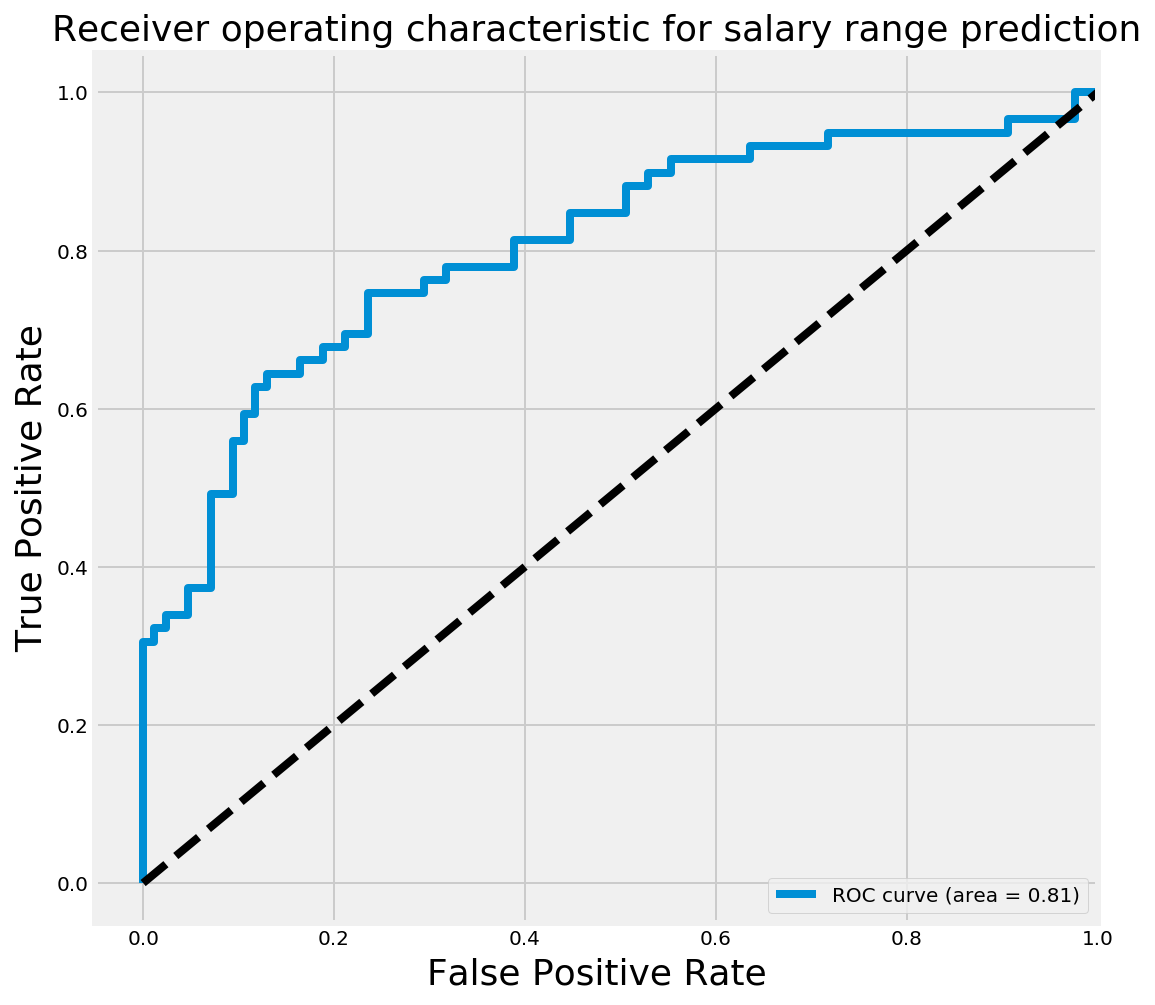

In [115]:
# For class 1 (salary range below $7200), find the area under the curve.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (salary range below $7200).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for salary range prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Fitting the best parameters for the logistic regression model on the test set, I obtained a AUC of 0.81. This is better than the baseline of 0.5.

Hence, I will study the coefficients of the model to understand the odds ratio of the top features.

In [116]:
# Find the odds ratio based on the coefficients from logisitic regression model

log_coef = pd.DataFrame(np.exp(logreg_g.coef_), columns = list(X_train.columns)).transpose()
log_coef.columns = ['Odds Ratio']
log_coef.sort_values(by='Odds Ratio', ascending=False)[:10]

,Odds Ratio
10 years,6.425468
Manager,5.147608
job_title_clean_management,3.645043
business stakeholders,3.615546
financial services,3.427823
experience years,3.276931
problem solving,3.267916
written verbal,3.148019
job_title_clean_data scientist,3.028224
real time,2.956059


#### Intepretation:

10 years experience, Manager, Management are key features that have the highest odds ratios for a high salary. Looking at the odds ratio, I conclude that the results of my logistic regression model is reasonable. 

It is also notable that the job title - data scientist has one of the highest odds ratio for high salary.

As logistic regression is a very basic and simple model, I will explore using another classifier - Random Forest Classifier to improve my prediction results.

### Random Forest Classifier Model

In [95]:
# Build a basic random forest classifier model 

rfc = RandomForestClassifier(n_jobs=-1)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=2, shuffle=True)

for train_index, test_index in skf.split(X_train,y_train):
    X_cross_train, X_cross_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
    sm = SMOTE(ratio='minority',k_neighbors=17, random_state=240)
    X_smote, y_smote = sm.fit_sample(X_cross_train, y_cross_train)
        
    rfc.fit(X_smote, y_smote)
    y_pred = rfc.predict(X_cross_test)
    y_pred_proba = rfc.predict_proba(X_cross_test)
        
    fpr, tpr, _ = roc_curve(y_cross_test, y_pred_proba[:,1])
    roc_auc = auc(fpr, tpr)

    print('The AUC for one fold is ',roc_auc)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The AUC for one fold is  0.7666093611357586
The AUC for one fold is  0.8113175675675676
The AUC for one fold is  0.7749155405405406


The AUC for the random forest classifier is approximately the same as my logistic regression model. This is likely because I have not tuned the parameters for the random forest classifier.

However, as my prediction results are already relatively good and my priority is to find out the features that affect salary, rather than purely to build the most accurate model to predict salary, I will not proceed to tune the parameters for the random forest classifier.

In [96]:
# Fit a random forest classifier model on the resampled X_train and y_train (X_smote and y_smote)
# Predict y_test 

rfc.fit(X_smote, y_smote)

y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)
        
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

print('The AUC is ',roc_auc)

The AUC is  0.7259222333000996


In [100]:
# Check feature importances to see which features might have the most impact

    # Get a list of the feature names
feat_labels = X_test.columns

feat_impt_df = pd.DataFrame(dict(zip(feat_labels, rfc.feature_importances_)),index=range(1)).transpose()
feat_impt_df.columns = ['Importance']
feat_impt_df = feat_impt_df.sort_values(by='Importance', ascending=False)

In [102]:
# Find the list of features that have feature importance >= 0.01

feat_impt_df

,Importance
financial services,0.029792
Sciences / Laboratory / R&D,0.028033
machine learning,0.027837
emp_type_clean_Permanent,0.026999
Manager,0.023853
years experience,0.022692
business analyst,0.022544
big data,0.020341
computer science,0.016525
Executive,0.015611


#### Note:

The values in the dataframe above indicate the importance of the features in the random forest classifier model. They do not show whether the features positive or negatively affects salary range. Hence, this model offers much less intepretability than a logistic regression model. 

### Cut down on the number of features used to improve the model

From the results above, we can see that many of the features do not contribute much to the model based on the features importance score above (e.g. with scores that are 0). Hence, I will remove the features that are less important. 

In [103]:
# Use SelectFromModel function and set threshold for feature importance at 0.01

sfm = SelectFromModel(rfc, threshold = 0.01)
sfm.fit(X_smote, y_smote)

X_impt_train = sfm.transform(X_smote)
X_impt_test = sfm.transform(X_test)

In [104]:
# Check results against the test set

rfc.fit(X_impt_train,y_smote)
y_pred = rfc.predict(X_impt_test)
y_pred_proba = rfc.predict_proba(X_impt_test)

print('Accuracy score: ',accuracy_score(y_test, y_pred))
print('Recall score: ',recall_score(y_test, y_pred, average='macro'))
print('Precision score: ',precision_score(y_test, y_pred, average='macro'))

Accuracy score:  0.6388888888888888
Recall score:  0.6189431704885344
Precision score:  0.623678208583869


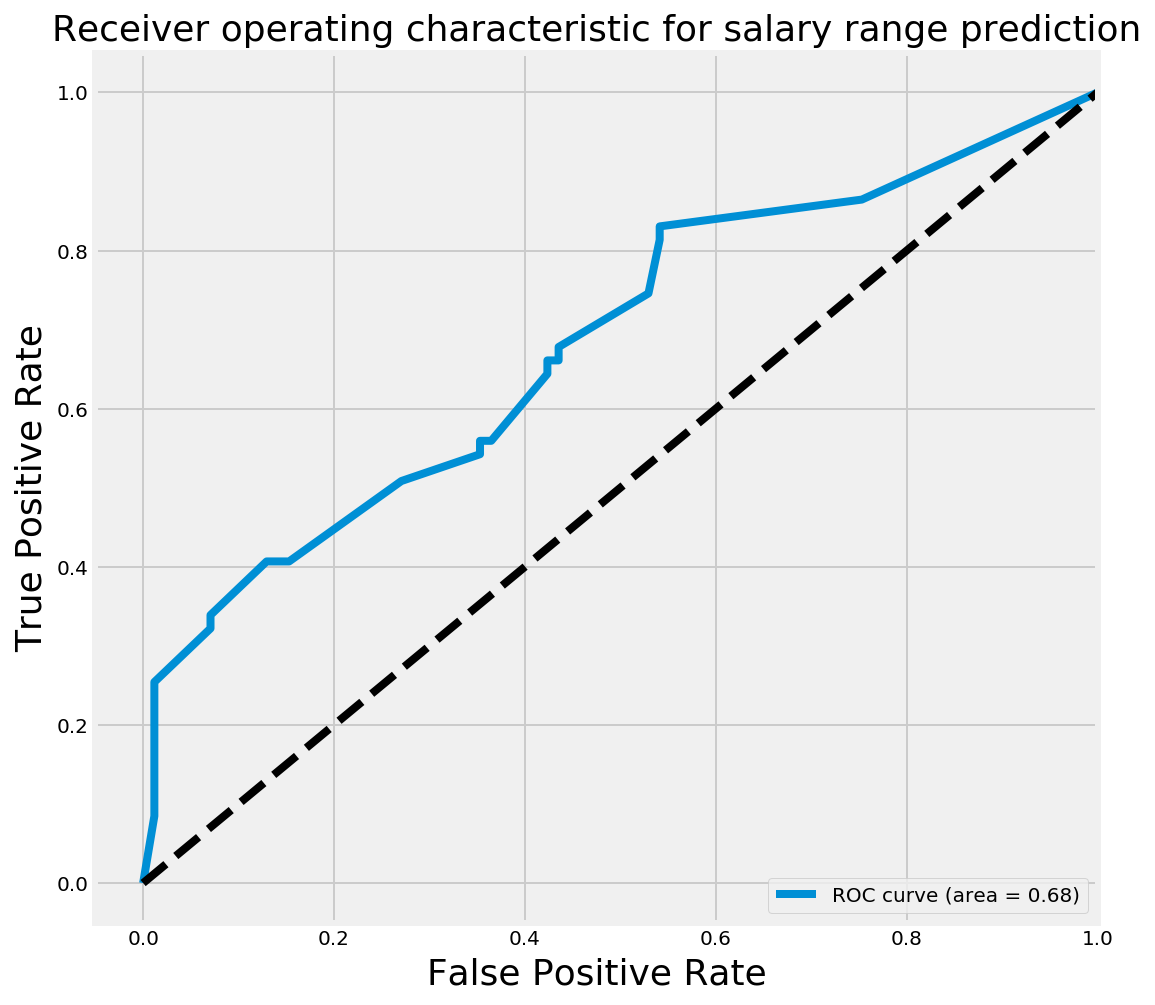

In [105]:
# For class 1, find the area under the curve.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (salary range below $7200).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for salary range prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

As expected, as I had removed some features from the model, the AUC score drops. However, the score is only slightly worse off and I obtained a less complex model. Hence, this simpler model may be better instead for predictions with better intepretability. 

In [118]:
# Try using the reduced number of features on a log regression model

logreg_g.fit(X_impt_train,y_smote)
y_pred = logreg_g.predict(X_impt_test)
y_pred_proba = logreg_g.predict_proba(X_impt_test)

print('Accuracy score: ',accuracy_score(y_test, y_pred))
print('Recall score: ',recall_score(y_test, y_pred, average='macro'))
print('Precision score: ',precision_score(y_test, y_pred, average='macro'))

Accuracy score:  0.5763888888888888
Recall score:  0.5685942173479561
Precision score:  0.5671875


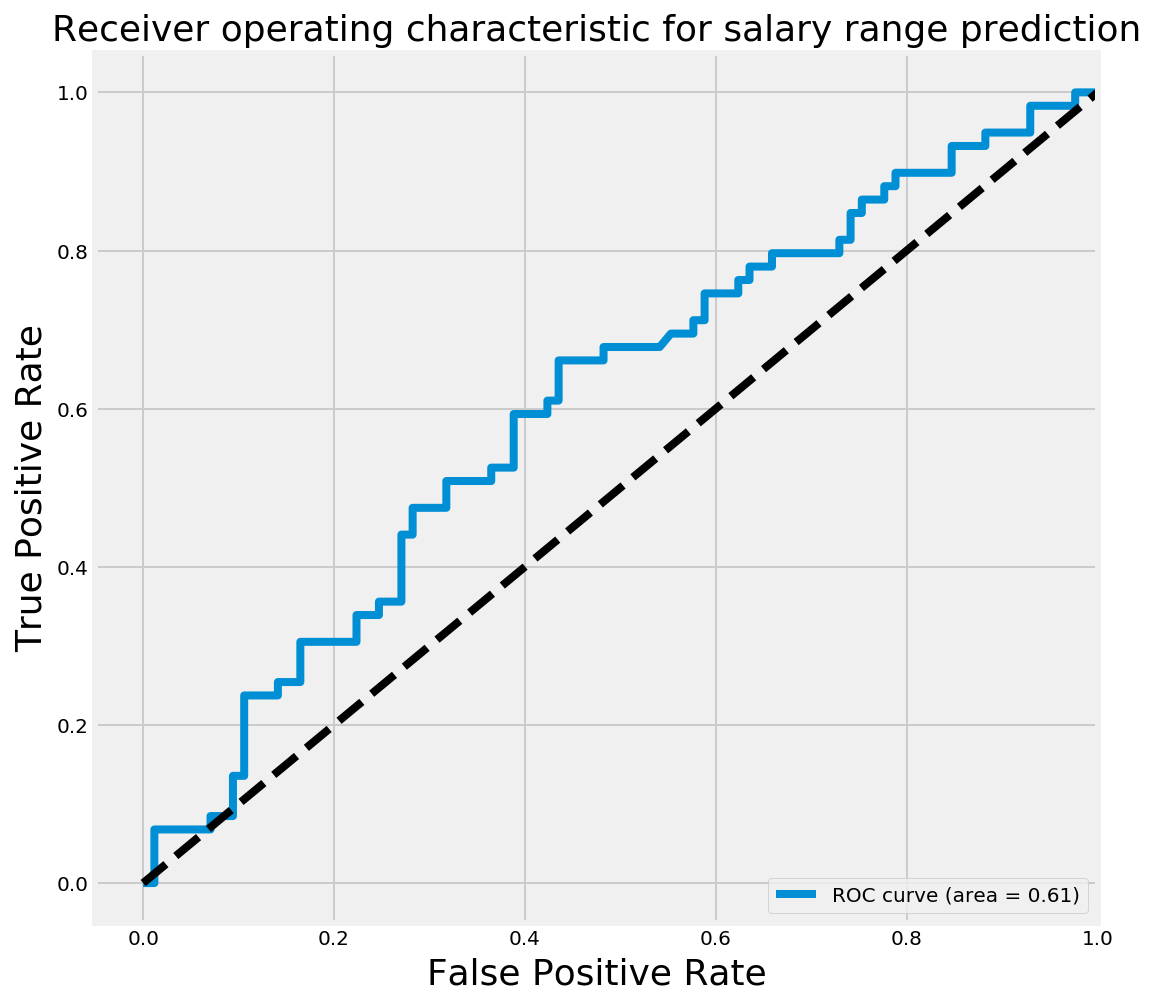

In [119]:
# For class 1, find the area under the curve.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (salary range below $7000).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for salary range prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

The log regression model now returns a very low score. Let's also study the coefficients of the new logistic regression model to find out the odds ratio of the different features. 

In [120]:
# Find the odds ratio based on the coefficients from logisitic regression model

log_coef1 = pd.DataFrame(np.exp(logreg_g.coef_), columns = list(feat_impt_df[:28].index)).transpose()
log_coef1.columns = ['Coefficient']
log_coef1.sort_values(by='Coefficient', ascending=False)[:10]

,Coefficient
10 years,2.897165
minimum years,2.568428
information technology,2.311474
computer science,2.234175
Fresh/entry level,1.482792
job_title_clean_management,1.402066
data science,1.393333
best practices,1.261568
Manager,1.243462
communication skills,1.179829


In [122]:
# Compare this against the results from my initial logistic regression model with all features

log_coef.columns = ['Odds Ratio']
log_coef.sort_values(by='Odds Ratio', ascending=False)[:10]

,Odds Ratio
10 years,6.425468
Manager,5.147608
job_title_clean_management,3.645043
business stakeholders,3.615546
financial services,3.427823
experience years,3.276931
problem solving,3.267916
written verbal,3.148019
job_title_clean_data scientist,3.028224
real time,2.956059


Looking at the results, the top features are very similar and are mostly relating to:
- Years of experience
- Management level / Manager
- Data Science

However, I also noticed that the logistic regression model using the most important features for the random forest classifier model includes the feature - 'Fresh/entry level' which has an odds ratio of 1.48. This does not make sense, as fresh/entry level jobs have been seen to be of a lower salary range according to the EDA done earlier. 

Hence, ultimately comparing the different models, I will choose to go with my initial logistic regression model. 

<font color = 'purple'>

# Executive Summary

_______

__Data used for the study__

For the purpose of this study, I used data extracted from web scrapping a local careers website. Due to the limited number of listings available at the point of study, there were only approximately 1000 samples collected. The study could be more accurate if there were >10k listings collected over a longer period. 


__Methodology__

As the data was directly scrapped from a website, it required a significant amount of data cleaning e.g. typos, converting strings to integers etc. prior to analyzing the data. 

In addition, many features e.g. employment types, required manual classification to consolidate them into distinct categories through EDA and research. This is because there were many overlapping categories in the raw data. The overlapping categories would complicate the analysis, which may then prevent meaningful study. 

However, with feature engineering, there is also a possibility of errors in my judgment, thus resulting in lost information, making the model less accurate. 

Logistic regression model was compared against the Random Forest Classifier to find the better model. They were compared based on their intepretability and the AUC scores of the predictions. The reason for using AUC score is to balance the True Positive and False Positive rate. 


__Findings__

The basic logistic regression model performed best in terms of the AUC score and interpretability. I could study the coefficients of the logistic regression model to find out the odds ratio of each feature. This in turn allows me to infer the 'importance' of the feature in getting high salary. 

The years of experience, Management level positions, Data Scientists, Financial services, managing business stakeholders, problem solving and written and verbal skills were identified as the features which have the most 'importance'/ likelihood in getting a high paying job. 

__Possible Application__

The model can be used to predict salary range and advise the salary range for a potential job based on the job description and requirements etc. 

For application, if a user would like to reduce incidences where the predicted salary range is higher than actual salary, the model can be tweaked to optimise precision score, i.e. by altering threshold for cutoff by studying the ROC plot. 

__Limitations__

As I focused on intepreting the results of the model, the model that I chose will not give an extremely good prediction based on the features. For a better prediction, we can look into other better peforming classification models eg. XGBoost and Support Vector Machine instead. 

A regression model predicting the salary amount instead of the salary range (high / low) would also have offered more value and intepretability. 